## Term frequency-inverse document frequency

특정 문서에서 자주 등장하지만 다른 문서에서는 그렇지 않은 단어에 더 많은 가중치를 주고 싶다.
사이킷런에서는 tf-idf 메쏘드를 두 개의 클래스로 구현한다.


하나는 TfidfTransformer 이고 다른 하나는 TfidfVectorizer 이다.

TfidfTransformer 는 CountVectorizer 로 만든 sparse matrix 를 입력값으로 받고

TfidfVectorizer 는 일반 텍스트를 받아서 bag-of-words 를 만들고 tf-idf 변환을 한다.

tf-idf 에는 몇 종류의 다른 버전이 있다. 

문서 d 의 단어 w 에 대한 tf-idf 점수는 다음과 같다.


\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

tf 는 단어 w 가 쿼리 문서(변환할 문서)에 나오는 횟수(빈도수?)

N 은 전체 문서의 수, N_w 는 단어 w 가 나온 문서의 수


---
tf-idf 스케일링은 특징적인 단어를 추출하는 것이 목적이다. 특징적인 단어가 꼭 레이블에 관계된 것이라고 단정적으로 생각할 수는 없다.


### 데이터 로딩

In [7]:
from sklearn.datasets import load_files

In [8]:
reviews_train = load_files("../data/text/classification_text/moview-review-aclImdb/train/")
reviews_test = load_files("../data/text/classification_text/moview-review-aclImdb/test/")

text_train, y_train = reviews_train.data, reviews_train.target
text_test, y_test = reviews_test.data, reviews_test.target

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

In [11]:
from sklearn.model_selection import GridSearchCV

시간이 너무 오래걸린다. 10분 이상

In [12]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
print("Best cv score: ", grid.best_score_)
print("Best cv params: ", grid.best_params_)

Best cv score:  0.89348
Best cv params:  {'logisticregression__C': 0.001}


스코어가 향상되었다.

파이프에서 훈련시킨 모델을 불러낼 수 있다.

In [14]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

# transform the training dataset:
x_train = vectorizer.transform(text_train)

In [22]:
x_train[0]  # 27272 개의 sparse matrix

<1x27272 sparse matrix of type '<class 'numpy.float64'>'
	with 91 stored elements in Compressed Sparse Row format>

In [24]:
vectorizer.get_feature_names()[::1000]

['00',
 'alternatively',
 'baked',
 'bothersome',
 'centers',
 'complicit',
 'cuties',
 'disgraced',
 'elsewhere',
 'fat',
 'gainey',
 'hamburger',
 'ideally',
 'ive',
 'leer',
 'martians',
 'mower',
 'opponents',
 'picaresque',
 'prude',
 'repairs',
 'saruman',
 'silverman',
 'stands',
 'talk',
 'trenches',
 'verify',
 'wreak']

In [15]:
# find maximum value for each of the features over datasets:
max_value = x_train.max(axis=0).toarray().ravel()

In [27]:
type(x_train.max(axis=0))

scipy.sparse.coo.coo_matrix

In [28]:
x_train.max(axis=0).toarray()

array([[ 20.15985557,  34.37105041,  16.70816476, ...,  25.46284132,
         28.0047349 ,   9.33491163]])

In [17]:
import numpy as np
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

In [18]:
print("features with lowest tfidf")
print(feature_names[sorted_by_tfidf[:20]])

features with lowest tfidf
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond' 'stinker'
 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing' 'downhill'
 'inane']


In [19]:
print("features with hightest tfidf")
print(feature_names[sorted_by_tfidf[-20:]])

features with hightest tfidf
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


### idf 수치만 따로 분석

idf 값이 작다는 것은 많은 문서에 등장한다는 말이다.

In [29]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("features with lowest idf")
print(feature_names[sorted_by_idf[:100]])

features with lowest idf
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'br' 'have' 'one' 'be' 'film' 'are' 'you'
 'all' 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his'
 'out' 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more'
 'when' 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really'
 'story' 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were'
 'other' 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how'
 'great' 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after'
 'any' 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen'
 'its']


In [30]:
vectorizer.idf_

array([ 6.71995186,  5.7285084 ,  8.35408238, ...,  8.48761377,
        9.33491163,  9.33491163])

## 계수가 높은 단어 시각화

In [31]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.

    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.

    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.

    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("coef")
    plt.xlabel("feature")


In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm = cm3

visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_,
                      feature_names, n_top_features=20)

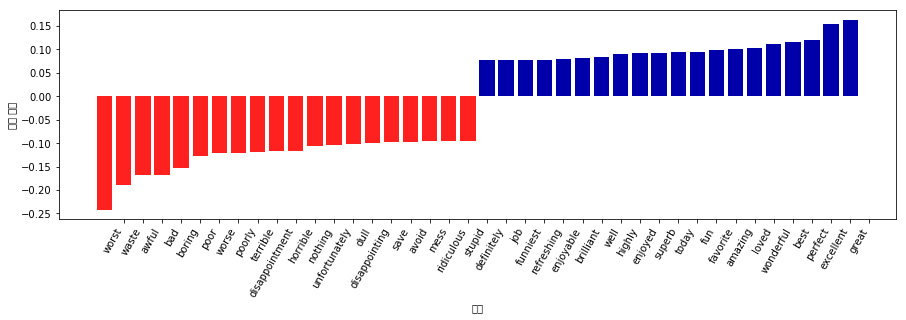

In [38]:
plt.show()